### Open street map search 

From Overpass Turbo, use this API and follow the instructions from the
URL below to quary OSM with python

https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

OSM CRS IS ----  'EPSG:4326'

#### Open Street Map Query for Cities and Villages 
URL for OSM Overpass Turbo: https://overpass-turbo.eu/


URL for OSM Features:
https://wiki.openstreetmap.org/wiki/Map_Features#Populated_settlements.2C_urban

#### Example from Ghana for Towns ... For cities, use *place=city*
    area["name"="Ghana"]->.boundaryarea;
    (
    node(area.boundaryarea)[place=town];
    way(area.boundaryarea)[place=town];>;
    rel(area.boundaryarea)[place=town];>>;
    );
    out meta;
    // print results
    out body;
    >;
    out skel qt;

In [29]:
import requests
import json

# geographies include city, town & village 
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Ghana"];
(node[place=city](area);
 way[place=city](area);
 rel[place=city](area);
);
out center;
"""

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [30]:
# number of elements stored 

len(data['elements'])

12

In [31]:
data

{'elements': [{'id': 27565080,
   'lat': 5.5600141,
   'lon': -0.2057437,
   'tags': {'admin_level': '2',
    'capital': 'yes',
    'capital_ISO3166-1': 'yes',
    'ele': '61',
    'is_capital': 'country',
    'is_in': 'Ghana',
    'is_in:continent': 'Africa',
    'is_in:country': 'Ghana',
    'is_in:country_code': 'GH',
    'is_in:iso_3166_2': 'GH-AA',
    'name': 'Accra',
    'name:ak': 'Nkran',
    'name:am': 'አክራ',
    'name:ar': 'أكرا',
    'name:arz': 'اكرا',
    'name:az': 'Akkra',
    'name:bat-smg': 'Akra',
    'name:be': 'Акра',
    'name:bg': 'Акра',
    'name:bo': 'ཨ་ཁ་ར།',
    'name:ckb': 'ئاکرا',
    'name:cv': 'Аккра',
    'name:de': 'Accra',
    'name:el': 'Άκκρα',
    'name:eo': 'Akrao',
    'name:es': 'Acra',
    'name:eu': 'Akkra',
    'name:fa': 'آکرا',
    'name:fr': 'Accra',
    'name:fy': 'Akkra',
    'name:he': 'אקרה',
    'name:ht': 'Akra',
    'name:hu': 'Accra',
    'name:hy': 'Ակրա',
    'name:is': 'Akkra',
    'name:ja': 'アクラ',
    'name:ka': 'აკრა',
    'n

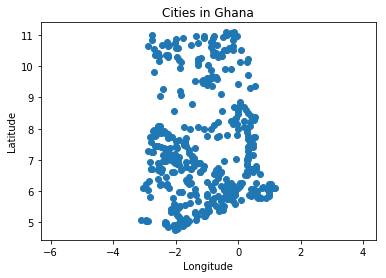

In [28]:
# plot them 

import numpy as np
import matplotlib.pyplot as plt

# Collect coords into list
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))
# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Cities in Ghana')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()